# [BEIT: BERT Pre-Training of Image Transformers](https://arxiv.org/pdf/2106.08254.pdf)

### Reference Code
- https://github.com/microsoft/unilm/tree/master/beit

<img src="./figures/beit_architecture.png" title="BEIT" />

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

np.random.seed(0)
torch.manual_seed(0)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print('Using device', device)

Using device cuda:1


In [2]:
# --------------------------------------------------------
# BEIT: BERT Pre-Training of Image Transformers (https://arxiv.org/abs/2106.08254)
# Github source: https://github.com/microsoft/unilm/tree/master/beit
# Copyright (c) 2021 Microsoft
# Licensed under The MIT License [see LICENSE for details]
# By Hangbo Bao
# Based on timm, mmseg, setr, xcit and swin code bases
# https://github.com/rwightman/pytorch-image-models/tree/master/timm
# https://github.com/fudan-zvg/SETR
# https://github.com/facebookresearch/xcit/
# https://github.com/microsoft/Swin-Transformer
# --------------------------------------------------------'
import math
import torch
from functools import partial
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint

from timm.models.layers import drop_path, to_2tuple, trunc_normal_

# from mmcv_custom import load_checkpoint
# from mmseg.utils import get_root_logger
# from mmseg.models.builder import BACKBONES

## Dataset and Dataloder

In [3]:
from torch.utils.data import random_split
from torchvision.transforms import ToTensor, Grayscale, Lambda
from torchvision import transforms

# Loading data
# transform = ToTensor()

transform = transforms.Compose([
    Grayscale(num_output_channels=3),  # Convert to 3 channels
    ToTensor(),
])

full_dataset = MNIST(root='./data/', train=True, download=True, transform=transform)
# Define the sizes for the training and validation sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size   # 20% for validation

# Split the dataset into training and validation sets
train_set, val_set = random_split(full_dataset, [train_size, val_size])
test_set = MNIST(root='./data/', train=False, download=True, transform=transform)

train_loader = DataLoader(train_set, shuffle=True, batch_size=16)
val_loader = DataLoader(val_set, shuffle=False, batch_size=16)
test_loader = DataLoader(test_set, shuffle=False, batch_size=16)

Using downloaded and verified file: ./data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 500618.64it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4625086.20it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 66378149.02it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
len(train_loader), len(val_loader), len(test_loader)

(3000, 750, 625)

torch.Size([16, 3, 28, 28])
torch.Size([16])
torch.Size([28, 28, 3])


8

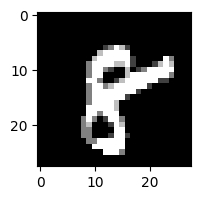

In [5]:
for images, labels in train_loader:  #taking 64 images, corresponding 64 labels
    break

print(images.shape) #(64 images, 1 channel, height, width)
print(labels.shape) #(class for the 64 images)

the_image = images[0]
the_image = np.transpose(the_image, (1, 2, 0))
print(the_image.shape)
plt.figure(figsize=(2, 2))
plt.imshow(the_image) #(h, w, c)

labels[0].item()

## BEiT Model

In [6]:
class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)
    
    def extra_repr(self) -> str:
        return 'p={}'.format(self.drop_prob)

In [7]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        # x = self.drop(x)
        # commit this for the orignal BERT implement 
        x = self.fc2(x)
        x = self.drop(x)
        return x


In [8]:
class Attention(nn.Module):
    def __init__(
            self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0.,
            proj_drop=0., window_size=None, attn_head_dim=None):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        if attn_head_dim is not None:
            head_dim = attn_head_dim
        all_head_dim = head_dim * self.num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, all_head_dim * 3, bias=False)
        if qkv_bias:
            self.q_bias = nn.Parameter(torch.zeros(all_head_dim))
            self.v_bias = nn.Parameter(torch.zeros(all_head_dim))
        else:
            self.q_bias = None
            self.v_bias = None

        if window_size:
            self.window_size = window_size
            self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
            self.relative_position_bias_table = nn.Parameter(
                torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH
            # cls to token & token 2 cls & cls to cls

            # get pair-wise relative position index for each token inside the window
            coords_h = torch.arange(window_size[0])
            coords_w = torch.arange(window_size[1])
            coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
            coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
            relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
            relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
            relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
            relative_coords[:, :, 1] += window_size[1] - 1
            relative_coords[:, :, 0] *= 2 * window_size[1] - 1
            relative_position_index = \
                torch.zeros(size=(window_size[0] * window_size[1] + 1, ) * 2, dtype=relative_coords.dtype)
            relative_position_index[1:, 1:] = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
            relative_position_index[0, 0:] = self.num_relative_distance - 3
            relative_position_index[0:, 0] = self.num_relative_distance - 2
            relative_position_index[0, 0] = self.num_relative_distance - 1

            self.register_buffer("relative_position_index", relative_position_index)

            # trunc_normal_(self.relative_position_bias_table, std=.0)
        else:
            self.window_size = None
            self.relative_position_bias_table = None
            self.relative_position_index = None

        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(all_head_dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, rel_pos_bias=None):
        B, N, C = x.shape
        qkv_bias = None
        if self.q_bias is not None:
            qkv_bias = torch.cat((self.q_bias, torch.zeros_like(self.v_bias, requires_grad=False), self.v_bias))
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        qkv = F.linear(input=x, weight=self.qkv.weight, bias=qkv_bias)
        qkv = qkv.reshape(B, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        if self.relative_position_bias_table is not None:
            relative_position_bias = \
                self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                    self.window_size[0] * self.window_size[1] + 1,
                    self.window_size[0] * self.window_size[1] + 1, -1)  # Wh*Ww,Wh*Ww,nH
            relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
            attn = attn + relative_position_bias.unsqueeze(0)

        if rel_pos_bias is not None:
            attn = attn + rel_pos_bias
        
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, -1)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x



In [9]:
class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., init_values=None, act_layer=nn.GELU, norm_layer=nn.LayerNorm,
                 window_size=None, attn_head_dim=None):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, window_size=window_size, attn_head_dim=attn_head_dim)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if init_values is not None:
            self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
            self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)),requires_grad=True)
        else:
            self.gamma_1, self.gamma_2 = None, None

    def forward(self, x, rel_pos_bias=None):
        if self.gamma_1 is None:
            x = x + self.drop_path(self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        else:
            x = x + self.drop_path(self.gamma_1 * self.attn(self.norm1(x), rel_pos_bias=rel_pos_bias))
            x = x + self.drop_path(self.gamma_2 * self.mlp(self.norm2(x)))
        return x

In [10]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        num_patches = (img_size[1] // patch_size[1]) * (img_size[0] // patch_size[0])
        self.patch_shape = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = num_patches

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x, **kwargs):
        B, C, H, W = x.shape
        # FIXME look at relaxing size constraints
        # assert H == self.img_size[0] and W == self.img_size[1], \
        #     f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]})."
        x = self.proj(x)
        Hp, Wp = x.shape[2], x.shape[3]

        x = x.flatten(2).transpose(1, 2)
        return x, (Hp, Wp)

In [11]:
img_size = 224 
patch_size = 28
in_chans = 3 
embed_dim = 768

patch_embed = PatchEmbed(
    img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)

x, (Hp, Wp) = patch_embed(images)
x.shape, Hp, Wp

(torch.Size([16, 1, 768]), 1, 1)

In [12]:
class HybridEmbed(nn.Module):
    """ CNN Feature Map Embedding
    Extract feature map from CNN, flatten, project to embedding dim.
    """
    def __init__(self, backbone, img_size=224, feature_size=None, in_chans=3, embed_dim=768):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        self.img_size = img_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                # FIXME this is hacky, but most reliable way of determining the exact dim of the output feature
                # map for all networks, the feature metadata has reliable channel and stride info, but using
                # stride to calc feature dim requires info about padding of each stage that isn't captured.
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))[-1]
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            feature_dim = self.backbone.feature_info.channels()[-1]
        self.num_patches = feature_size[0] * feature_size[1]
        self.proj = nn.Linear(feature_dim, embed_dim)

    def forward(self, x):
        x = self.backbone(x)[-1]
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x

In [13]:
class RelativePositionBias(nn.Module):

    def __init__(self, window_size, num_heads):
        super().__init__()
        self.window_size = window_size
        self.num_relative_distance = (2 * window_size[0] - 1) * (2 * window_size[1] - 1) + 3
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(self.num_relative_distance, num_heads))  # 2*Wh-1 * 2*Ww-1, nH
        # cls to token & token 2 cls & cls to cls

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(window_size[0])
        coords_w = torch.arange(window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * window_size[1] - 1
        relative_position_index = \
            torch.zeros(size=(window_size[0] * window_size[1] + 1,) * 2, dtype=relative_coords.dtype)
        relative_position_index[1:, 1:] = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        relative_position_index[0, 0:] = self.num_relative_distance - 3
        relative_position_index[0:, 0] = self.num_relative_distance - 2
        relative_position_index[0, 0] = self.num_relative_distance - 1

        self.register_buffer("relative_position_index", relative_position_index)

        # trunc_normal_(self.relative_position_bias_table, std=.02)

    def forward(self):
        relative_position_bias = \
            self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
                self.window_size[0] * self.window_size[1] + 1,
                self.window_size[0] * self.window_size[1] + 1, -1)  # Wh*Ww,Wh*Ww,nH
        return relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww



In [14]:
class BEiT(nn.Module):
    """ 
    Vision Transformer with support for patch or hybrid CNN input stage
    """
    def __init__(
        self, 
        img_size=224, 
        patch_size=16, 
        in_chans=3, 
        num_classes=1000, 
        embed_dim=768, 
        depth=12,
        num_heads=12, 
        mlp_ratio=4., 
        qkv_bias=False, 
        qk_scale=None, 
        drop_rate=0., 
        attn_drop_rate=0.,
        drop_path_rate=0., 
        norm_layer=nn.LayerNorm, 
        init_values=None,
        use_abs_pos_emb=False, 
        use_rel_pos_bias=False, 
        use_shared_rel_pos_bias=False,
        use_mean_pooling=True, 
        init_scale=0.001
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # self.mask_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        if use_abs_pos_emb:
            self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        else:
            self.pos_embed = None
        self.pos_drop = nn.Dropout(p=drop_rate)

        if use_shared_rel_pos_bias:
            self.rel_pos_bias = RelativePositionBias(window_size=self.patch_embed.patch_shape, num_heads=num_heads)
        else:
            self.rel_pos_bias = None

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.use_rel_pos_bias = use_rel_pos_bias
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer,
                init_values=init_values, window_size=self.patch_embed.patch_shape if use_rel_pos_bias else None)
            for i in range(depth)])
        self.norm = nn.Identity() if use_mean_pooling else norm_layer(embed_dim)
        self.fc_norm = norm_layer(embed_dim) if use_mean_pooling else None
        self.head = nn.Linear(embed_dim, num_classes) if num_classes > 0 else nn.Identity()

        if self.pos_embed is not None:
            trunc_normal_(self.pos_embed, std=.02)
        trunc_normal_(self.cls_token, std=.02)
        # trunc_normal_(self.mask_token, std=.02)
        if isinstance(self.head, nn.Linear):
            trunc_normal_(self.head.weight, std=.02)
        self.apply(self._init_weights)
        self.fix_init_weight()

        if isinstance(self.head, nn.Linear):
            self.head.weight.data.mul_(init_scale)
            self.head.bias.data.mul_(init_scale)

    def fix_init_weight(self):
        def rescale(param, layer_id):
            param.div_(math.sqrt(2.0 * layer_id))

        for layer_id, layer in enumerate(self.blocks):
            rescale(layer.attn.proj.weight.data, layer_id + 1)
            rescale(layer.mlp.fc2.weight.data, layer_id + 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def get_num_layers(self):
        return len(self.blocks)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x, (Hp, Wp) = self.patch_embed(x)
        batch_size, seq_len, _ = x.size()

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        x = self.pos_drop(x)

        rel_pos_bias = self.rel_pos_bias() if self.rel_pos_bias is not None else None
        for blk in self.blocks:
            x = blk(x, rel_pos_bias=rel_pos_bias)

        x = self.norm(x)
        if self.fc_norm is not None:
            t = x[:, 1:, :]
            return self.fc_norm(t.mean(1))
        else:
            return x[:, 0]
        
    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

    def get_intermediate_layers(self, x):
        x, (Hp, Wp) = self.patch_embed(x)
        batch_size, seq_len, _ = x.size()

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        if self.pos_embed is not None:
            x = x + self.pos_embed
        x = self.pos_drop(x)

        features = []
        rel_pos_bias = self.rel_pos_bias() if self.rel_pos_bias is not None else None
        for blk in self.blocks:
            x = blk(x, rel_pos_bias)
            features.append(x)

        return features


In [15]:
model = BEiT(
    img_size = 224, 
    patch_size = 16,
    in_chans = 3,
    embed_dim = 768,
    num_classes = 10,
    depth       = 12,
    num_heads   = 12,
    mlp_ratio   = 4
).to(device)

model

BEiT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=False)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): Identity()
  (fc_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (head): Lin

## Training

In [16]:
import torch.optim as optim

num_epochs = 5
lr = 0.01

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = CrossEntropyLoss()

In [17]:
def train(model, train_loader, optimizer, criterion, device="cpu"):
    
    model.train()
    train_loss = 0.0
    train_correct, total = 0, 0

    for batch in tqdm(train_loader):
        x, y = batch
        x = x.to(device) #16, 3, 28, 28 
        y = y.to(device) #16

        y_hat = model(x)
        loss = criterion(y_hat, y) / len(x)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
        total += len(x)

    return train_loss, train_correct/total

def evaluate(model, loader, criterion):

    model.eval()
    test_loss = 0.0
    test_correct, total = 0, 0
    
    for batch in tqdm(loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        
        y_hat = model(x)
        loss = criterion(y_hat, y) / len(x)
        test_loss += loss.item()

        test_correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
        total += len(x)

    return test_loss, test_correct/total

In [18]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    valid_loss, test_acc = evaluate(model, val_loader, criterion)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} | Test  Acc: {test_acc * 100:.2f}%')
    #lower perplexity is better

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 01 | Time: 1m 28s
	Train Loss: 230.185 | Train Acc: 59.26%
	 Val. Loss: 36.520 | Test  Acc: 74.02%


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 02 | Time: 1m 43s
	Train Loss: 134.680 | Train Acc: 75.91%
	 Val. Loss: 29.218 | Test  Acc: 79.74%


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 03 | Time: 1m 33s
	Train Loss: 109.066 | Train Acc: 80.75%
	 Val. Loss: 24.959 | Test  Acc: 82.90%


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 04 | Time: 1m 22s
	Train Loss: 101.547 | Train Acc: 82.10%
	 Val. Loss: 22.062 | Test  Acc: 84.44%


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

Epoch: 05 | Time: 1m 38s
	Train Loss: 92.482 | Train Acc: 83.59%
	 Val. Loss: 24.367 | Test  Acc: 82.67%


Text(0, 0.5, 'loss')

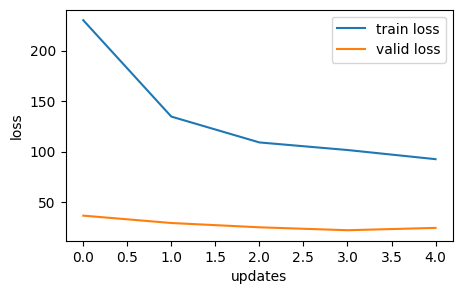

In [20]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [21]:
# model.load_state_dict(torch.load(save_path))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f'\t Test. Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

  0%|          | 0/625 [00:00<?, ?it/s]

	 Test. Loss: 19.469 | Test Acc: 83.30%
